## Продвинутое машинное обучение: ДЗ 1
## Кошелев Александр DS-21

### Часть 1

#### 1.1
Прокурор оценил вероятность виновности вероятностью принадленжости подсудимого к редкой группе крови группе крови. А должен был оценить вероятность виновности при условии принадлежности подсудимого к этой группе крови.

#### 1.2
Адвокат оценил вероятность невиновности вероятностью выбора подсудимого из множества людей с данной группой крови. А должен был оценить вероятность невиновности при условии принадлежности подсудимого в этой группе крови.

#### 1.3

Построим 2 графика с изменением вероятности False-Positive, False-Negative. p_1 вероятность ошибки False_Positive, p_2 - False-Negative. P_A - Вероятность появления  положительного теста. P_B - вероятность того что болен. P_AB - вероятность положительного теста при условии что болен. P_BA - вероятность того что болен при наличии положительного теста

In [137]:
import matplotlib.pyplot as plt
import numpy as np

In [138]:
p_1_default = 0.05
p_2_default = 0.05
P_B = 0.01

In [139]:
def get_posterior(p_1, p_2):
    P_B = 0.01
    P_A = p_1 * 0.99 + (1 - p_2) * 0.01
    P_AB = (1 - p_2)
    return P_AB * P_B / P_A

In [140]:
get_posterior(0.05, 0.05)

0.16101694915254236

In [141]:
p_list = np.linspace(0, 0.05, 20)

In [142]:
#Вероятности со снижением false-negative
p_apost_fn = [get_posterior(p_1_default, p_2_new) for p_2_new in p_list]
#Вероятности со снижением false-positive
p_apost_fp = [get_posterior(p_1_new, p_2_default) for p_1_new in p_list]

In [143]:
p_apost_fn, p_apost_fp

([0.1680672268907563,
  0.16769911504424778,
  0.16733067729083664,
  0.1669619131975199,
  0.16659282233052725,
  0.16622340425531912,
  0.16585365853658537,
  0.16548358473824315,
  0.16511318242343542,
  0.16474245115452932,
  0.1643713904931142,
  0.16399999999999998,
  0.16362827923521567,
  0.1632562277580071,
  0.1628838451268358,
  0.16251113089937666,
  0.1621380846325167,
  0.16176470588235292,
  0.1613909942041908,
  0.16101694915254236],
 [1.0,
  0.7847826086956522,
  0.6457960644007156,
  0.5486322188449849,
  0.47688243064729197,
  0.4217289719626168,
  0.37801047120418846,
  0.3425047438330171,
  0.31309627059843886,
  0.2883386581469648,
  0.2672094744633605,
  0.2489655172413793,
  0.23305358295674627,
  0.21905339805825239,
  0.20663995420721237,
  0.19555796316359694,
  0.18560411311053984,
  0.17661448140900196,
  0.16845543630424636,
  0.16101694915254236])

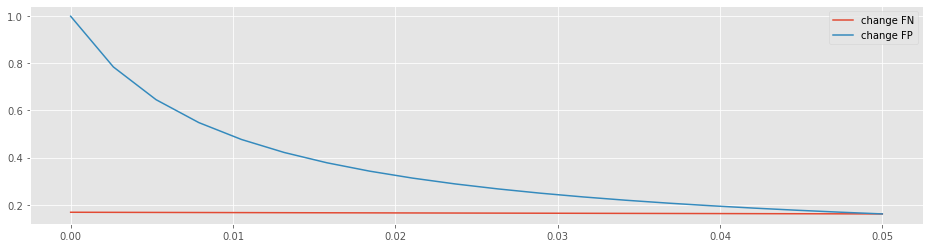

In [144]:
plt.plot(p_list, p_apost_fn, label='change FN')
plt.plot(p_list, p_apost_fp, label='change FP')
plt.legend()

Вывод: нужно снижать вероятность для false-positive, если хотят увеличить вероятность того что человек действительно болен при положительном тесте.
Но надо понимать, что если не снизить false-negative - 5% реально больных не будут выявлены. Что может закончиться печально.
В жизни все зависит целей, ресурсов и возможностей. И исходя из этого найти оптимальный вариант снижения обоих типов ошибки

## Часть 2

In [145]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import seaborn as sns

palette = sns.color_palette()
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (16, 4)

In [146]:
data = pd.read_csv('owid-covid-data.csv')

In [147]:
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


Отфильтруем только нужные данные

In [148]:
data = data[(data['location'] == 'Russia') & (data['date'] >= '2020-03-03')]

In [149]:
data = data.set_index('date')

<AxesSubplot:xlabel='date'>

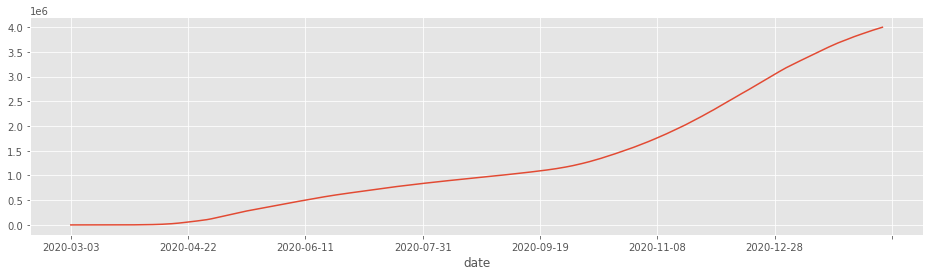

In [150]:
data['total_cases'].plot()

<AxesSubplot:xlabel='date'>

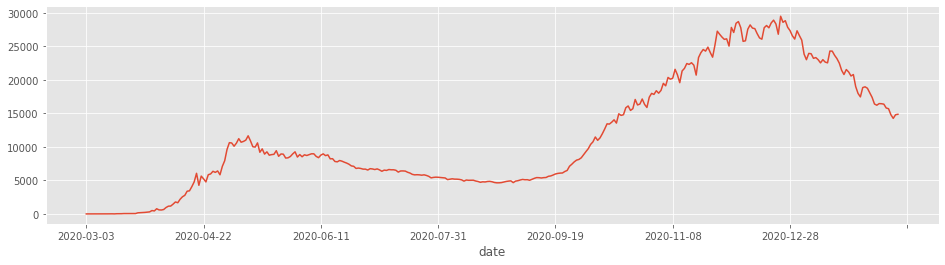

In [151]:
data['new_cases'].plot()

In [152]:
data['new_cases'] = data['new_cases'].replace(0, 1)

In [153]:
train = data.iloc[:50].copy()

In [154]:
test = data.iloc[50:].copy()

### 2.a

<AxesSubplot:xlabel='date'>

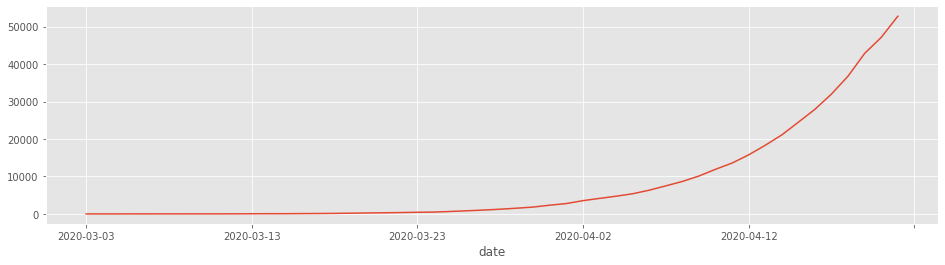

In [155]:
train['total_cases'].plot()

In [156]:
train['day_number'] = np.arange(0, 50, 1)

In [157]:
train['day_number_exp'] = np.exp(train['day_number'])

In [158]:
lr_t = LinearRegression()

In [159]:
lr_t.fit(train[['day_number_exp']], train['total_cases'])

LinearRegression()

<AxesSubplot:xlabel='date'>

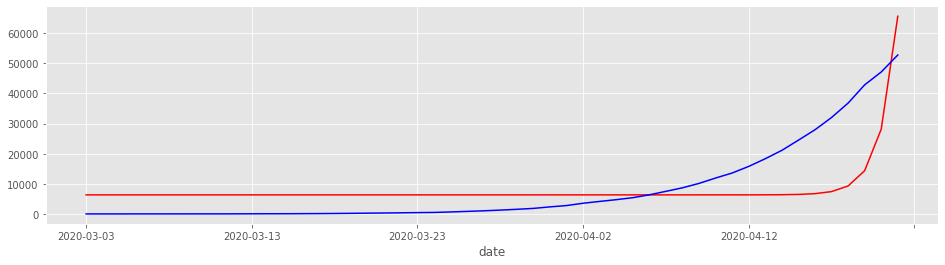

In [160]:
plt.plot(lr_t.predict(train[['day_number_exp']]), color='red')
train['total_cases'].plot(color='blue')

Нормализуем экспоненту номера дня для удобной визуализации

In [161]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [162]:
cur_mu, cur_sigma = np.array([0.5, 0.5]), \
    2*np.array([[1, 0], [0, 1]])

In [163]:
# Нарисуем результат
def plot_predictions(xs, mu, x, points):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.set_ylim((-2, 2))
    ax.plot(xs, true_curve(xs), label="Правильный ответ")
    ax.plot(xs, mu[1]*xs + mu[0], color="red", label="MAP гипотеза")
    ax.fill_between(xs, mu[1]*xs + mu[0] - .25, mu[1]*xs + mu[0] + .25, color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.scatter(points[0], points[1], marker='*', s=200)
    ax.legend(fontsize=legend_fontsize)

In [164]:
for i in range(train.shape[0]):
    x, y = train['day_number_exp'].iloc[i], train['total_cases'].iloc[i]
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, x, y)

In [165]:
x = train['day_number_exp']

In [166]:
errors = []
for i in range(50):
    x = train['day_number_exp'].iloc[i]
    y = cur_mu[1]*x + cur_mu[0]
    errors.append(train['total_cases'].iloc[i] - y)

In [167]:
np.mean(errors), np.std(errors)

(3.9509470265743585, 10079.13151164957)

In [168]:
noize_disp = np.var(errors)

In [169]:
x = train['day_number_exp']

### 2.b
Параметры апостериорного распреления:

In [170]:
cur_mu, cur_sigma

(array([6.32201524e+03, 3.10947767e-17]),
 array([[ 1.30569312e-03, -9.36395517e-25],
        [-9.36395517e-25,  1.55264075e-44]]))

Дисперсия шума и его стандартное отклонение

In [171]:
noize_disp, np.sqrt(noize_disp)

(101588892.02912733, 10079.13151164957)

### 2.с

In [172]:
from datetime import datetime

In [173]:
# Число дней до 1 сентября
datetime(2020, 9, 1) - datetime(2020, 3, 3)

datetime.timedelta(days=182)

In [174]:
# Число дней до 1 июня
datetime(2020, 6, 1) - datetime(2020, 3, 3)

datetime.timedelta(days=90)

In [175]:
# Число дней до 1 мая
datetime(2020, 5, 1) - datetime(2020, 3, 3)

datetime.timedelta(days=59)

In [176]:
exp_1may = np.exp(59)
exp_1june = np.exp(90)
exp_1sept = np.exp(182)

In [177]:
my_w = np.random.multivariate_normal(cur_mu, cur_sigma, 50)
result_1may = []
result_1june = []
result_1sept = []
for i, w in enumerate(my_w):
    result_1may.append(w[0] + w[1]*exp_1may)
    result_1june.append(w[0] + w[1]*exp_1june)
    result_1sept.append(w[0] + w[1]*exp_1sept)
#     print(f'Iter: {i} 1 june estimated total cases {w[0] + w[1]*exp_1june}')
#     print(f'Iter: {i} 1 sept estimated total cases {w[0] + w[1]*exp_1sept}')

### Усредненные результаты 50-и экспонент на 1 июня и 1 сентября

In [178]:
np.mean(result_1may), np.mean(result_1june), np.mean(result_1sept)

(1306363403.8984747, 3.794817048059492e+22, 3.4220250004489683e+62)

In [179]:
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs
    return res

In [180]:
x = np.arange(0, 52, 1)
x_exp = np.exp(x)

In [181]:
x_pred = sample_statistics(cur_mu, cur_sigma, x, n=100)

In [182]:
np.mean(x_pred, axis=0)

array([6322.01466193, 6322.01466193, 6322.01466193, 6322.01466193,
       6322.01466193, 6322.01466193, 6322.01466193, 6322.01466193,
       6322.01466193, 6322.01466193, 6322.01466193, 6322.01466193,
       6322.01466193, 6322.01466193, 6322.01466193, 6322.01466193,
       6322.01466193, 6322.01466193, 6322.01466193, 6322.01466193,
       6322.01466193, 6322.01466193, 6322.01466193, 6322.01466193,
       6322.01466193, 6322.01466193, 6322.01466193, 6322.01466193,
       6322.01466193, 6322.01466193, 6322.01466193, 6322.01466193,
       6322.01466193, 6322.01466193, 6322.01466193, 6322.01466193,
       6322.01466193, 6322.01466193, 6322.01466193, 6322.01466193,
       6322.01466193, 6322.01466193, 6322.01466193, 6322.01466193,
       6322.01466193, 6322.01466193, 6322.01466193, 6322.01466193,
       6322.01466193, 6322.01466193, 6322.01466193, 6322.01466193])

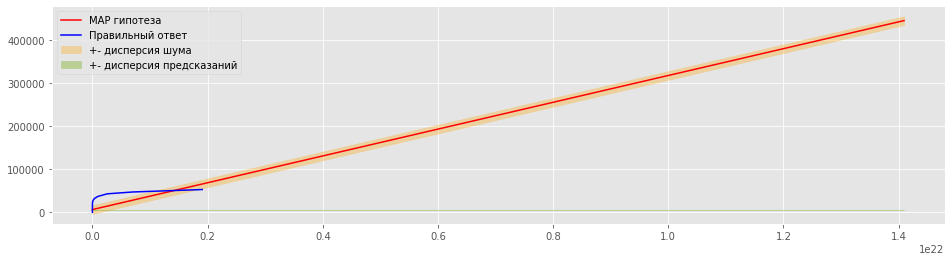

In [183]:
plt.plot(x_exp, cur_mu[1]*x_exp + cur_mu[0], color='red', label="MAP гипотеза")
plt.plot(train['day_number_exp'], train['total_cases'], color='blue', label="Правильный ответ")
plt.fill_between(x_exp, cur_mu[1]*x_exp + cur_mu[0] - np.sqrt(noize_disp), cur_mu[1]*x_exp + cur_mu[0]  + np.sqrt(noize_disp), color='orange', alpha=.3, label="+- дисперсия шума")
plt.fill_between(x_exp, np.mean(x_pred, axis=0) - np.std(x_pred, axis=0), np.mean(x_pred, axis=0) + np.std(x_pred, axis=0), color=palette[5], alpha=.5, label="+- дисперсия предсказаний")
plt.legend()

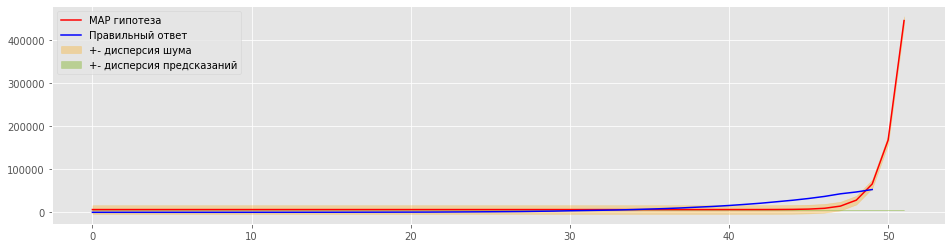

In [184]:
plt.plot(x, cur_mu[1]*x_exp + cur_mu[0], color='red', label="MAP гипотеза")
plt.plot(train['day_number'], train['total_cases'], color='blue', label="Правильный ответ")
plt.fill_between(x, cur_mu[1]*x_exp + cur_mu[0] - np.sqrt(noize_disp), cur_mu[1]*x_exp + cur_mu[0]  + np.sqrt(noize_disp), color='orange', alpha=.3, label="+- дисперсия шума")
plt.fill_between(x, np.mean(x_pred, axis=0) - np.std(x_pred, axis=0), np.mean(x_pred, axis=0) + np.std(x_pred, axis=0), color=palette[5], alpha=.5, label="+- дисперсия предсказаний")
plt.legend()

## Часть 3

### 3.a
Для решения предлагаю количество дней нормализовать с помощью Standart Scaler. Затем для получения из этого нужного признака использовать значение функции распределения нормального распределения с параметрами 0, 1 от значения преобразованного дня

In [633]:
st_sc = StandardScaler()

In [634]:
st_sc.fit(np.arange(0, 200, 1).reshape(-1, 1))

StandardScaler()

In [635]:
train['day_number_for_sigm'] = multivariate_normal.cdf(st_sc.transform(train[['day_number']]), mean=0, cov=1)

### 3.b

In [636]:
cur_mu, cur_sigma = np.array([0, 0]), \
    2*np.array([[1, 0], [0, 1]])

In [637]:
for i in range(train.shape[0]):
    x, y = train['day_number_for_sigm'].iloc[i], train['total_cases'].iloc[i]
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, x, y)

In [638]:
x_sigm = st_sc.transform(np.arange(0, 52, 1).reshape(-1, 1))

In [639]:
x_sigm = multivariate_normal.cdf(x_sigm.reshape(1, -1)[0], mean=0, cov=1)

In [640]:
errors = []
for i in range(50):
    x = train['day_number_for_sigm'].iloc[i]
    y = cur_mu[1]*x + cur_mu[0]
    errors.append(train['total_cases'].iloc[i] - y)

np.mean(errors), np.std(errors)

noize_disp = np.var(errors)

In [641]:
np.sqrt(noize_disp)

7492.376561644662

In [642]:
x_pred = sample_statistics(cur_mu, cur_sigma, x_sigm, n=100)  

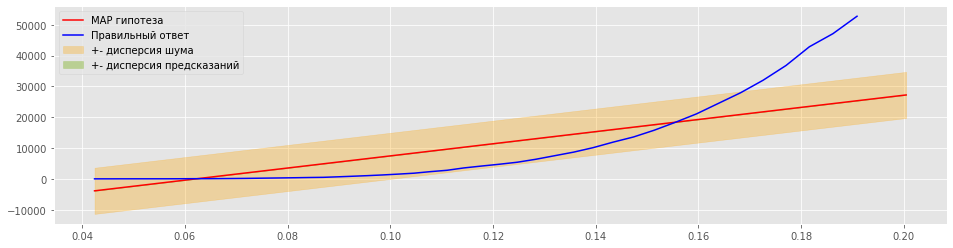

In [643]:
plt.plot(x_sigm, cur_mu[1]*x_sigm + cur_mu[0], color='red', label="MAP гипотеза")
plt.plot(train['day_number_for_sigm'], train['total_cases'], color='blue', label="Правильный ответ")
plt.fill_between(x_sigm, cur_mu[1]*x_sigm + cur_mu[0] - np.sqrt(noize_disp), cur_mu[1]*x_sigm + cur_mu[0]  + np.sqrt(noize_disp), color='orange', alpha=.3, label="+- дисперсия шума")
plt.fill_between(x_sigm, np.mean(x_pred, axis=0) - np.std(x_pred, axis=0), np.mean(x_pred, axis=0) + np.std(x_pred, axis=0), color=palette[5], alpha=.5, label="+- дисперсия предсказаний")
plt.legend()

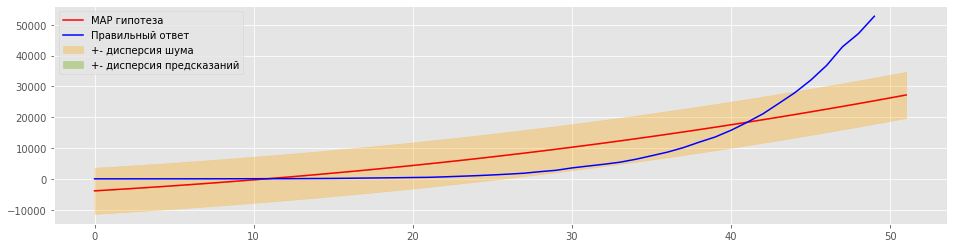

In [644]:
plt.plot(np.arange(0, 52, 1), cur_mu[1]*x_sigm + cur_mu[0], color='red', label="MAP гипотеза")
plt.plot(train['day_number'], train['total_cases'], color='blue', label="Правильный ответ")
plt.fill_between(np.arange(0, 52, 1), cur_mu[1]*x_sigm + cur_mu[0] - np.sqrt(noize_disp), cur_mu[1]*x_sigm + cur_mu[0]  + np.sqrt(noize_disp), color='orange', alpha=.3, label="+- дисперсия шума")
plt.fill_between(np.arange(0, 52, 1), np.mean(x_pred, axis=0) - np.std(x_pred, axis=0), np.mean(x_pred, axis=0) + np.std(x_pred, axis=0), color=palette[5], alpha=.5, label="+- дисперсия предсказаний")
plt.legend()

### 3.c

In [645]:
cur_mu

array([-12233.58909066, 196876.74801837])

In [646]:
lr = LinearRegression()
lr.fit(train[['day_number_for_sigm']], train['total_cases'])

LinearRegression()

In [647]:
my_w = np.random.multivariate_normal(cur_mu, cur_sigma, 30)
res = [np.zeros((30, 3))][0]
x_for_pred = st_sc.transform(np.array([59, 90, 182]).reshape(-1, 1))
x_for_pred = multivariate_normal.cdf(x_for_pred, mean=0, cov=1)
for i,w in enumerate(my_w):
    res[i, 0] = w[0] + w[1]*x_for_pred[0]
    res[i, 1] = w[0] + w[1]*x_for_pred[1]
    res[i, 2] = w[0] + w[1]*x_for_pred[2]

In [648]:
x_for_pred = st_sc.transform(np.array([59, 90, 182]).reshape(-1, 1))
x_for_pred = multivariate_normal.cdf(x_for_pred, mean=0, cov=1)

In [649]:
np.quantile(res, 0.9, axis=0)

array([ 35312.07569414,  73339.31440066, 169581.42418249])

In [650]:
np.quantile(res, 0.1, axis=0)

array([ 35311.7531853 ,  73338.57135432, 169579.6029136 ])

In [632]:
data['total_cases'].loc['2020-05-01'], data['total_cases'].loc['2020-06-01'], data['total_cases'].loc['2020-09-01']

(114431.0, 414328.0, 997072.0)